## Optimization :
   # Newtons Method
   # Conjugate Gradient Method 
   # Interior Point Methods (IPM)
   # Quadratic Programming


In [1]:
from utility.data_loader import load_parquet_data
from utility.data_transformer import transform_data
import utility.wt_comparision as wt_comparision
from pathlib import Path
import optimizers.basic as basic
import optimizers.newtons_method as newtons_method
import optimizers.cg_optimizer as cg_optimizer
import lib_optimizers.qp_solver as qp_solver
import lib_optimizers.scipy_solvers as scipy_solvers
from optimizers.ipm_optimizer import solve_with_ipm, plot_ipm_convergence
from optimizers.ipm_with_hirarchy_constraint import solve_with_ipm_complete



In [2]:
faireness_coefficient = 0.5
regularization_coefficient=0.2

In [3]:
# Load the data
parquet_file_path = Path().absolute().parent / 'data' / 'breuninger_user_product_event_counts_000000000000'
my_data_df = load_parquet_data(str(parquet_file_path), engine='pyarrow')  

# Transform the data only if DataFrame is loaded successfully
if my_data_df is not None:
	data_for_optimization = transform_data(my_data_df, lambda_1=faireness_coefficient, lambda_2=regularization_coefficient)
else:
	raise ValueError("Failed to load data from parquet file")

In [4]:
# # Summarize Data for QP Solver
# if data_for_optimization:
#     print("\n--- Data Summary for QP Solver ---")
#     print(f"Number of Weights (K): {data_for_optimization['weights_count']}")
#     print(f"Weight Names (Event Types): {data_for_optimization['weight_names']}")
#     print("\nShape of Raw Interaction Matrix (E - M x K):", data_for_optimization['E'].shape)
#     print("Shape of Transformed Interaction Matrix (A - M x K):", data_for_optimization['A'].shape)
#     # Display a snippet of the interaction matrix
#     print("\nSnippet of Interaction Matrix (A):")
#     print(data_for_optimization['A'][:10, :5])  # Display first 10 rows and first 5 columns as a sample
#     #  Q - hessian matrix and c - linear term vector
#     print("\nShape of Q (Hessian Matrix - K x K):", data_for_optimization['Q_solver'].shape)
#     print("Shape of c (Linear Term Vector - K x 1):", data_for_optimization['c'].shape) 
#     # Display complete Q  and c
#     print("\nHessian Matrix (Q):")
#     print(data_for_optimization['Q_solver'])
#     print("\nLinear Term Vector (c):")
#     print(data_for_optimization['c'])   
# else:
#     raise ValueError("Data transformation failed, cannot summarize data.")

In [5]:
hierarchy = [
    ('purchase', 'add_to_cart'),          # purchase >= add_to_cart
    ('add_to_cart', 'add_to_wishlist'),   # add_to_cart >= add_to_wishlist
    ('add_to_wishlist', 'product_view')   # add_to_wishlist >= product_view
]
result_solve_constrained_quadratic = scipy_solvers.solve_constrained_quadratic(data_for_optimization['Q_solver'], data_for_optimization['c'], data_for_optimization['weight_names'], hierarchy=hierarchy)

print(f"Max Objective Score (f(w)): {result_solve_constrained_quadratic['max_f_w']}")
print(result_solve_constrained_quadratic['weights_df'])


Max Objective Score (f(w)): 87715.30260041586
     Weight          Feature
0  0.199186      add_to_cart
1  0.199382  add_to_wishlist
2  0.208599     product_view
3  0.199186         purchase
4  0.199708        view_cart



Projected Newton's Method Execution (K=5 Features)
Goal: Minimize g(w) = 1/2 w^T Q w - c^T w, subject to Simplex Constraints
--- Initial Setup ---
  > Initial Objective (Min g(w)): -85066.727304
  > Initial Weights: add_to_cart: 0.2000, add_to_wishlist: 0.2000, product_view: 0.2000, purchase: 0.2000, view_cart: 0.2000
--- Iteration 01 ---
  > Current Objective (Min g(w)): -314199.563433
  > Gradient Norm: 321957.997646
  > Step Change (|w_next - w|): 0.894427
  > Current Weights: add_to_cart: 0.0000, add_to_wishlist: 0.0000, product_view: 1.0000, purchase: 0.0000, view_cart: 0.0000
--- Iteration 02 ---
  > Current Objective (Min g(w)): -314199.563433
  > Gradient Norm: 321956.826672
  > Step Change (|w_next - w|): 0.000000
  > Current Weights: add_to_cart: 0.0000, add_to_wishlist: 0.0000, product_view: 1.0000, purchase: 0.0000, view_cart: 0.0000

[INFO] CONVERGENCE: Step change is below tolerance.

[INFO] Total Iterations: 2
[INFO] Time elapsed: 0.0001 seconds

[INFO] Plotting converg

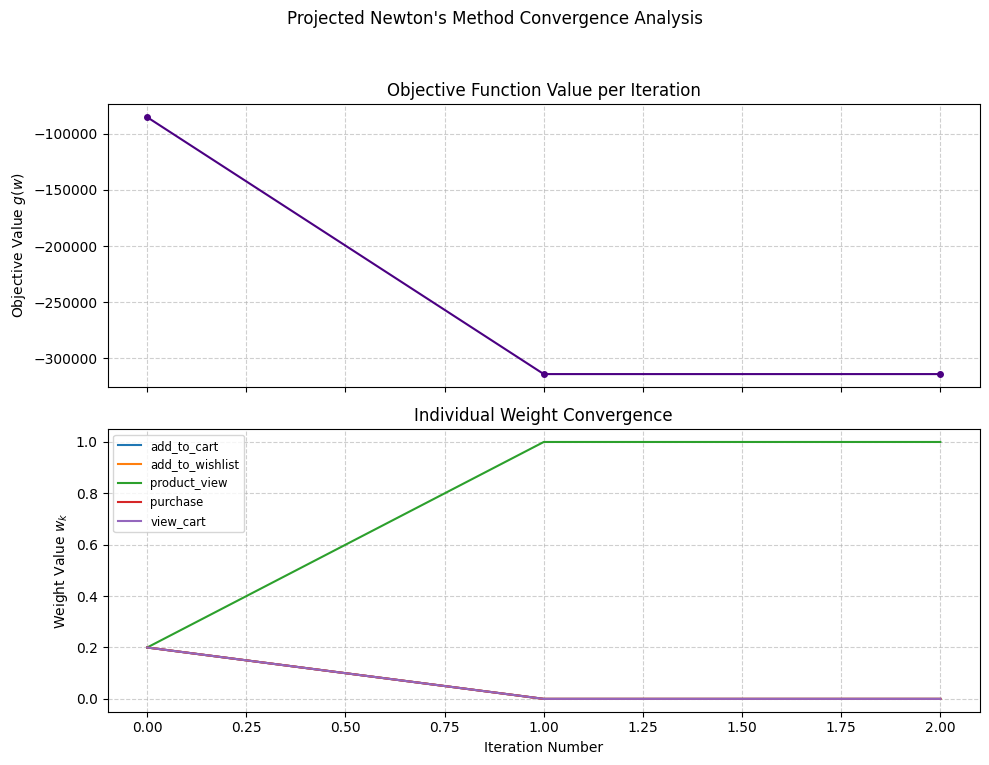

In [6]:
# Newton's Method Optimization
result_newtons_method=newtons_method.solve_with_projected_newtons_method(data_for_optimization['Q_solver'], data_for_optimization['c'], data_for_optimization['weight_names'] )
if 'history' in result_newtons_method and result_newtons_method['history']:
        print("\n[INFO] Plotting convergence history...")
        newtons_method.plot_convergence(result_newtons_method['history'], data_for_optimization['weight_names'])



Projected Conjugate Gradient Method Execution (K=5 Features)
Goal: Minimize g(w) = 1/2 w^T Q w - c^T w, subject to Simplex Constraints
--- Initial Setup ---
  > Initial Objective (Min g(w)): -85066.727304
  > Initial Weights: add_to_cart: 0.2000, add_to_wishlist: 0.2000, product_view: 0.2000, purchase: 0.2000, view_cart: 0.2000
--- Iteration 01 ---
  > Current Objective: -85066.727304
  > Step Change: 0.894427
  > Current Weights: add_to_cart: 0.0000, add_to_wishlist: 0.0000, product_view: 1.0000, purchase: 0.0000, view_cart: 0.0000
--- Iteration 02 ---
  > Current Objective: -314199.563433
  > Step Change: 0
  > Current Weights: add_to_cart: 0.0000, add_to_wishlist: 0.0000, product_view: 1.0000, purchase: 0.0000, view_cart: 0.0000

[INFO] CONVERGENCE: Step change (0.00e+00) is below tolerance (1.00e-07).

[INFO] Total Iterations: 3
[INFO] Time elapsed: 0.0005 seconds
[INFO] Final Sum of Weights: 1.0

[INFO] Plotting convergence history...


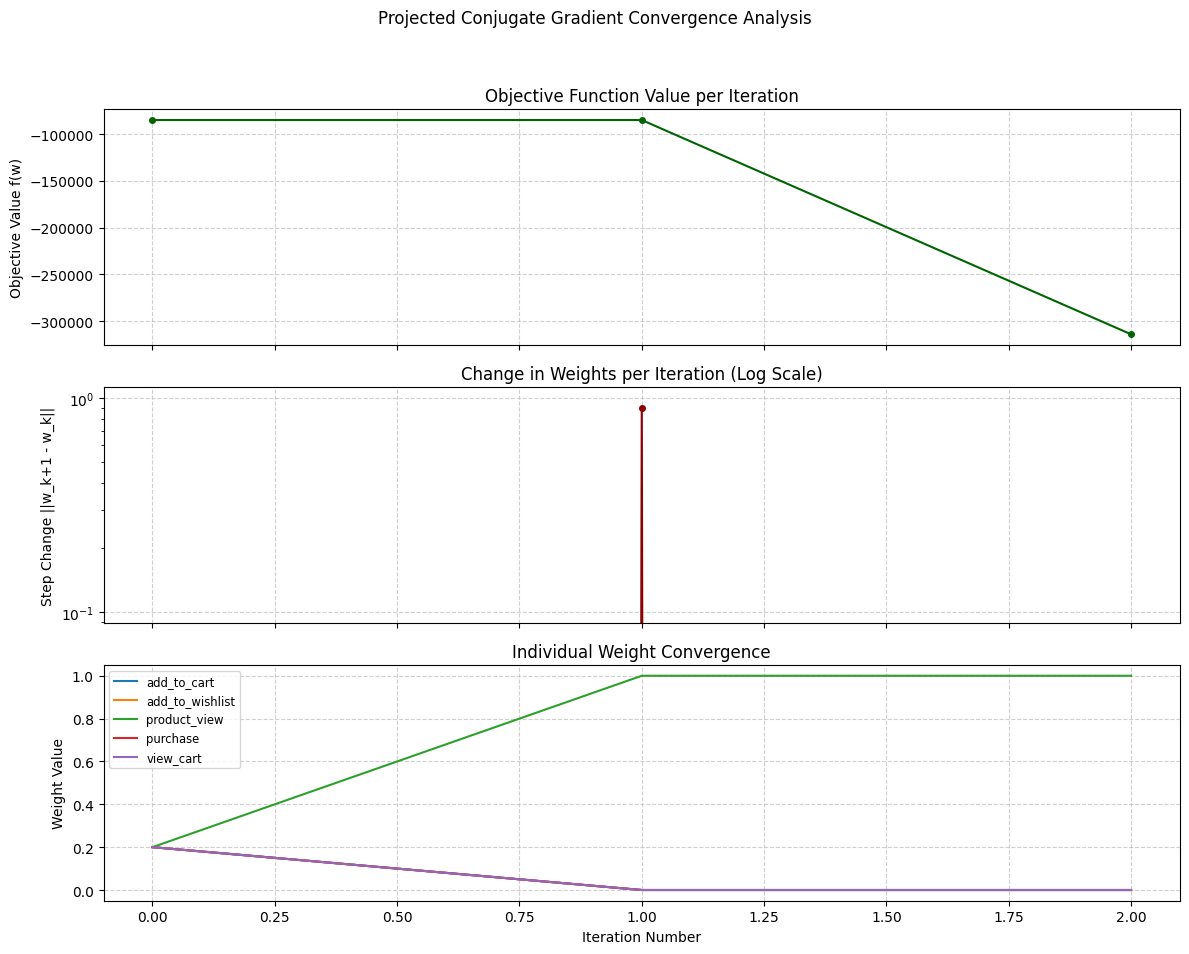

In [7]:
# Conjugate Gradient Method Optimization
result_cg_method=cg_optimizer.solve_with_conjugate_gradient(data_for_optimization['Q_solver'], data_for_optimization['c'], data_for_optimization['weight_names'] )
if 'history' in result_cg_method and result_cg_method['history']:
        print("\n[INFO] Plotting convergence history...")
        cg_optimizer.plot_cg_convergence(result_cg_method['history'], data_for_optimization['weight_names'])  


Primal-Dual Interior Point Method Execution (K=5 Features)
Goal: Minimize g(w) = 1/2 w^T Q w - c^T w, subject to Simplex Constraints
--- Initial Setup ---
  > Initial Objective (Min g(w)): -85066.727304
  > Initial Weights: add_to_cart: 0.2000, add_to_wishlist: 0.2000, product_view: 0.2000, purchase: 0.2000, view_cart: 0.2000
--- Iteration 01 ---
  > Current Objective: -85066.727304
  > Duality Gap: 0.2
  > Current Weights: add_to_cart: 0.2000, add_to_wishlist: 0.2000, product_view: 0.2000, purchase: 0.2000, view_cart: 0.2000
--- Iteration 02 ---
  > Current Objective: -141165.978988
  > Duality Gap: 0.152974
  > Current Weights: add_to_cart: 0.1463, add_to_wishlist: 0.1412, product_view: 0.3876, purchase: 0.1260, view_cart: 0.1989
--- Iteration 03 ---
  > Current Objective: -233148.438920
  > Duality Gap: 0.10197
  > Current Weights: add_to_cart: 0.0577, add_to_wishlist: 0.0512, product_view: 0.7039, purchase: 0.0379, view_cart: 0.1493
--- Iteration 04 ---
  > Current Objective: -293

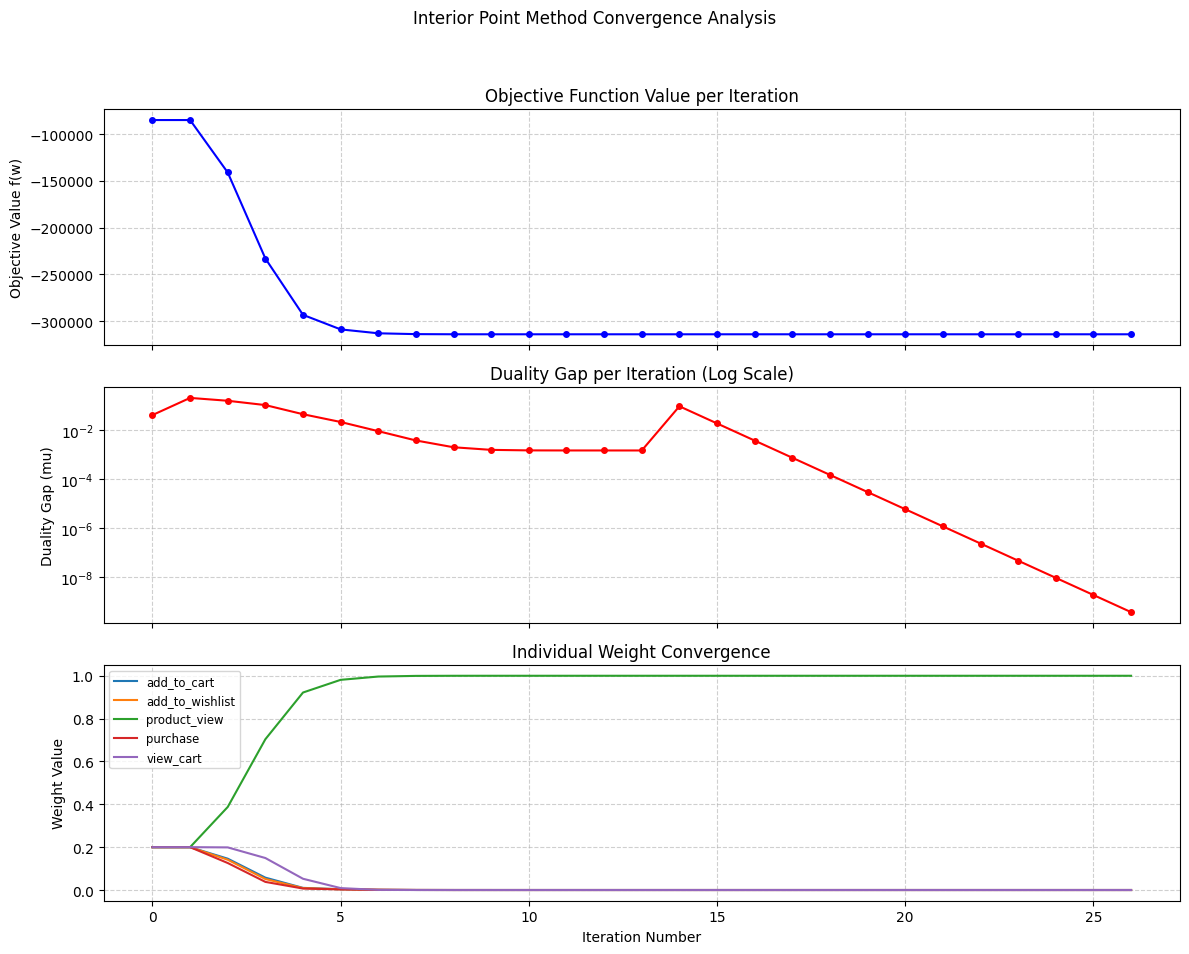

In [8]:
# Solve with IPM Solver
res_ipm = solve_with_ipm(data_for_optimization['Q_solver'], data_for_optimization['c'], data_for_optimization['weight_names'] )

if 'history' in res_ipm and res_ipm['history']:
    print("\n[INFO] Plotting IPM convergence history...")
    plot_ipm_convergence(res_ipm['history'], data_for_optimization['weight_names']) 
    


Primal-Dual Interior Point Method Execution (K=5 Features, J=3 Hierachy Constraints)
Iter   1 | Gap: 1.25e-02 | Obj: -6.7922e+04 | Alpha: 0.000
Iter  10 | Gap: 1.30e-01 | Obj: -2.0267e+05 | Alpha: 0.000
Iter  20 | Gap: 1.30e-01 | Obj: -3.1420e+05 | Alpha: 0.000
Iter  30 | Gap: 3.99e-01 | Obj: -3.1420e+05 | Alpha: 0.000
Iter  40 | Gap: 1.11e-01 | Obj: -3.1420e+05 | Alpha: 0.074
Iter  50 | Gap: 9.55e-02 | Obj: -3.1420e+05 | Alpha: 0.000
Iter  60 | Gap: 8.38e-02 | Obj: -3.1420e+05 | Alpha: 0.000
Iter  70 | Gap: 1.49e+00 | Obj: -3.1420e+05 | Alpha: 0.000
Iter  80 | Gap: 1.15e+00 | Obj: -3.1420e+05 | Alpha: 0.000
Iter  90 | Gap: 9.28e-02 | Obj: -3.1420e+05 | Alpha: 0.000
Iter 100 | Gap: 1.20e-01 | Obj: -3.1420e+05 | Alpha: 0.000

Optimization Complete in 0.0079 seconds.
Final Weights: {'add_to_cart': np.float64(3.989355015288199e-08), 'add_to_wishlist': np.float64(2.2912087313359334e-08), 'product_view': np.float64(0.9999999138751011), 'purchase': np.float64(1.155520998537021e-08), 'view_c

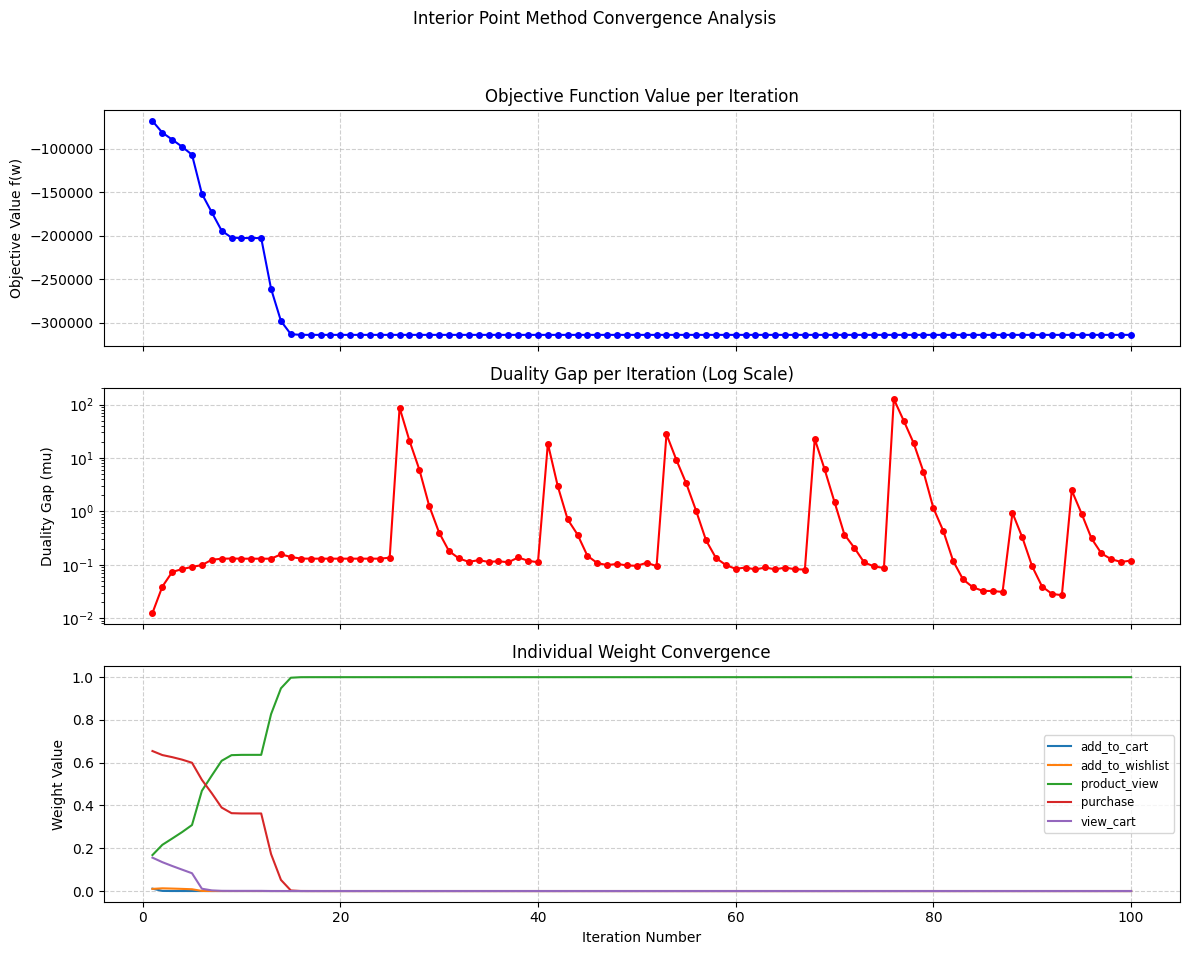

In [9]:

# Solve with IPM Solver with hirarchy
res_ipm_complete = solve_with_ipm_complete(data_for_optimization['Q_solver'], data_for_optimization['c'], data_for_optimization['weight_names'] )

if 'history' in res_ipm_complete and res_ipm_complete['history']:
    print("\n[INFO] Plotting IPM convergence history...")
    plot_ipm_convergence(res_ipm_complete['history'], data_for_optimization['weight_names']) 


In [10]:
# Quadratic Programming Solver Optimization
qp_results_hirarchy_constrained = qp_solver.solve_quadratic_programming(data_for_optimization, constraints_type='hierarchy')
# Simplex Constrained QP Solver Optimization
qp_results_simple_constrained = qp_solver.solve_quadratic_programming(data_for_optimization, constraints_type='simple')



Applying Logical Hierarchy Constraint:
  Constraint: w['purchase'] >= w['add_to_cart']
  Constraint: w['add_to_cart'] >= w['product_view']

--- Optimization Results ---
Solver Status: optimal
Maximized Objective Value (f(w)): 114047.1890

Optimal Weight Vector (w*):
             Event  Optimal_Weight
0      add_to_cart    3.333333e-01
1  add_to_wishlist   -7.762925e-24
2     product_view    3.333333e-01
3         purchase    3.333333e-01
4        view_cart   -7.495022e-24

Applying Simple Constraints (Normalization + Non-Negativity only).

--- Optimization Results ---
Solver Status: optimal
Maximized Objective Value (f(w)): 314199.5634

Optimal Weight Vector (w*):
             Event  Optimal_Weight
0      add_to_cart   -6.339716e-23
1  add_to_wishlist   -6.339716e-23
2     product_view    1.000000e+00
3         purchase   -6.339716e-23
4        view_cart    4.788049e-23


In [11]:
# Heuristic Weights Calculation Method
heuristic_results = basic.calculate_heuristic_weights(data_for_optimization)

# Log-sum Weights Calculation Method
log_sum_results = basic.calculate_log_sum_weights(data_for_optimization)



Visualization



--- Generating Final Score Comparison ---


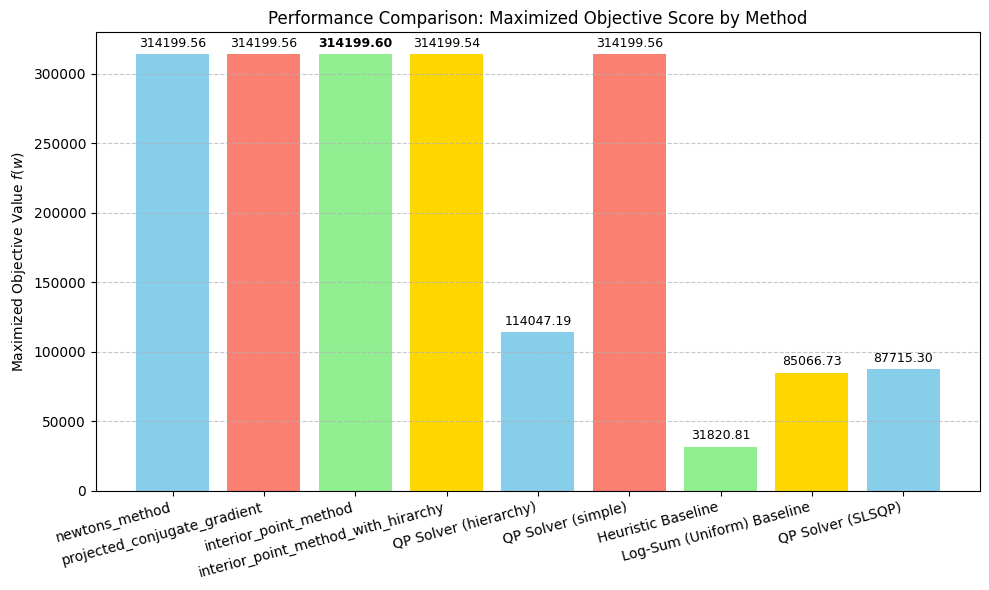

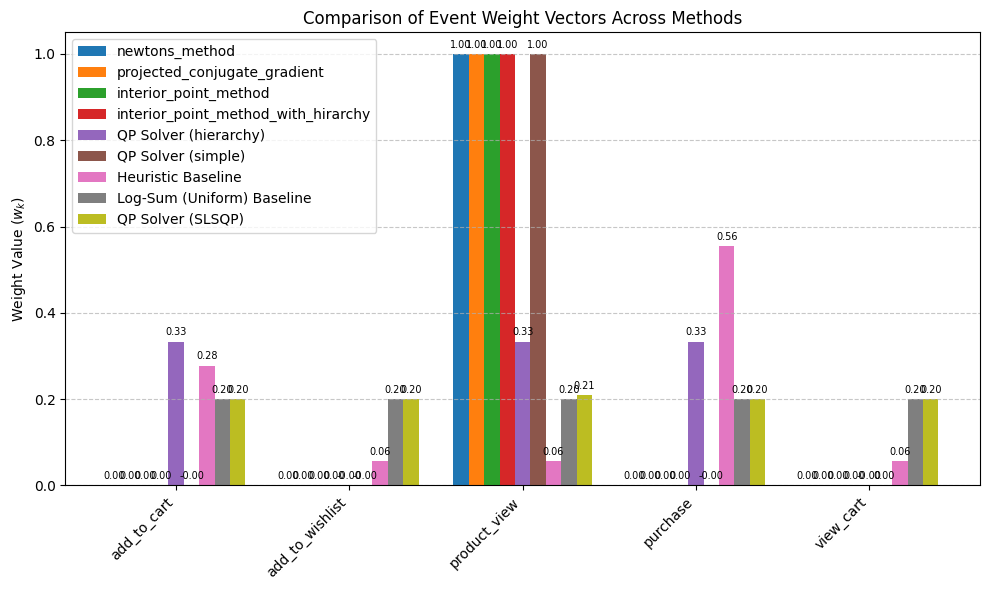


--- Best Optimization Method Found ---
Method: interior_point_method
Max Objective Score (f(w)): 314199.5975

Weights for the Best Method:
                       Weight
Event                        
add_to_cart      2.545810e-16
add_to_wishlist  2.533110e-16
product_view     1.000000e+00
purchase         2.432463e-16
view_cart        2.983599e-16


In [12]:
# List to collect all weight vectors for comparison
all_weight_results = []
all_weight_results.append({**result_newtons_method, 'weight_names': data_for_optimization['weight_names']})
all_weight_results.append({**result_cg_method, 'weight_names': data_for_optimization['weight_names']})
all_weight_results.append({**res_ipm, 'weight_names': data_for_optimization['weight_names']})
all_weight_results.append({**res_ipm_complete, 'weight_names': data_for_optimization['weight_names']})

all_weight_results.append({**qp_results_hirarchy_constrained, 'weight_names': data_for_optimization['weight_names']})
all_weight_results.append({**qp_results_simple_constrained, 'weight_names': data_for_optimization['weight_names']})
all_weight_results.append({**heuristic_results, 'weight_names': data_for_optimization['weight_names']})
all_weight_results.append({**log_sum_results, 'weight_names': data_for_optimization['weight_names']})

all_weight_results.append({**result_solve_constrained_quadratic, 'weight_names': data_for_optimization['weight_names']})

#Visualize the Final Scores =
print("\n\n--- Generating Final Score Comparison ---")
wt_comparision.visualize(data_for_optimization,all_weight_results)